In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from torchsampler import ImbalancedDatasetSampler

import torch
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np 

from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm
import pandas as pd 

import matplotlib.pyplot as plt

import sys
sys.path.append('../../')
from network import multi_models as models

from sklearn.metrics import recall_score, f1_score, accuracy_score

{0.0: 3}


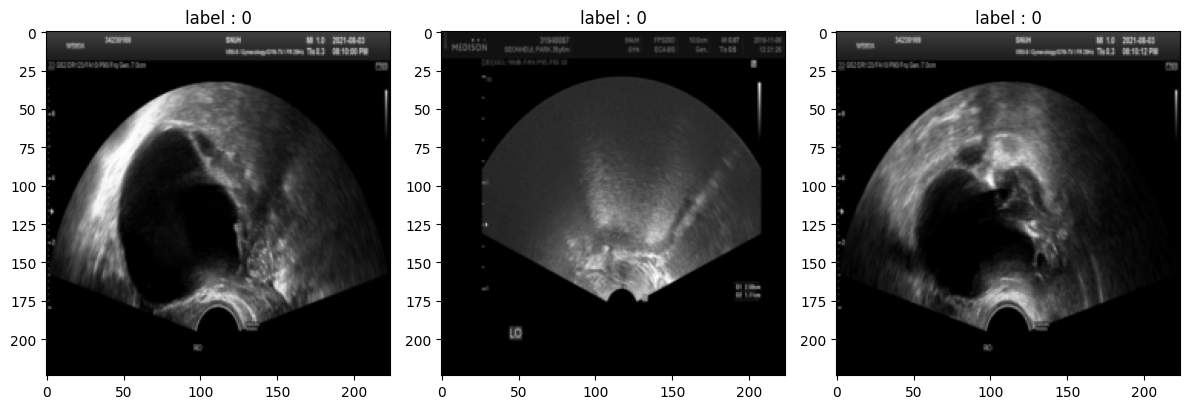

In [2]:
test_dir = '/home/eiden/eiden/DB/octc/data_multi_origin/test'
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True),
    transforms.Grayscale(num_output_channels=3),
])
test_batch = 3
test_dataset = CustomDataset(root_dir = test_dir, transform= test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = test_batch, shuffle= True)

for i, (image, label) in enumerate(test_loader):
    unique, cnts = np.unique(label, return_counts= True)
    print(dict(zip(unique, cnts)))
    plt.figure(figsize= (12, 8))
    plt.subplot(131)
    plt.imshow(image[0,0], cmap ='gray')
    plt.title(f"label : {label[0].int().item()}")
    plt.subplot(132)
    plt.imshow(image[1,0], cmap ='gray')
    plt.title(f"label : {label[1].int().item()}")
    plt.subplot(133)
    plt.imshow(image[2,0], cmap ='gray')
    plt.title(f"label : {label[2].int().item()}")
    plt.tight_layout()
    plt.show()
    break

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Convnext
# checkpoint_path = '../../../models/multi/convnext_original_240326/convnext_original_240326_50_e.pt' #original model
# checkpoint_path = '../../../models/multi/convnext_original_ntr_240327/convnext_original_ntr_240327_50_e.pt' #not inpainting just sono model
# checkpoint_path = '../../../models/multi/convnext_sonography_240326/convnext_sonography_240326_50.pt' #not inpainting just sono model
# checkpoint_path = '../../../models/multi/convnext_sono_ntr_240327/convnext_sono_ntr_240327_50.pt' #not inpainting just sono model
# checkpoint_path = '../../../models/multi/convnext_ours_240404/convnext_ours_240404_50.pt' #Ours model
# test_model = models.pretrained_convnext_multi().to(device) 

### Swin-T
# checkpoint_path = '../../../models/multi/swin_v2_original_240327/swin_v2_original_240327_50.pt' #original model
checkpoint_path = '../../../models/multi/swin_v2_original_ntr_240327/swin_v2_original_ntr_240327_50.pt' #original model
# checkpoint_path = '../../../models/multi/swin_v2_sonography_240326/swin_v2_sonography_240326_50.pt' #not inpainting just sono model
# checkpoint_path = '../../../models/multi/swin_ours_240404/swin_ours_240404_50.pt' #Ours model
test_model = models.pretrained_swin_multi().to(device) 

checkpoint = torch.load(checkpoint_path)
weight = checkpoint['model_state_dict']

test_model.load_state_dict(state_dict = weight)
print(f'load complete!! device : {device}')

/home/eiden/anaconda3/envs/eiden/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load complete!! device : cuda


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_curve, auc

correct = 0
total = 0
predicted_labels = []
predicted_scores = []
true_labels = []

In [5]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

def metric_func(true_labels, predicted_labels, predicted_scores, metrics_dict):
    accuracy = correct / total
    metrics_dict["acc"] = accuracy

    # F1 Score 계산
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    metrics_dict["f1-score"] = f1

    # Recall 계산
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    metrics_dict["recall"] = recall

    # Specificity 계산 - 평균으로 취함 
    num_classes = 3
    specificity = []
    for class_label in range(num_classes):
        true_positives = np.sum((np.array(true_labels) == class_label) & (np.array(predicted_labels) == class_label))
        total_actual_class = np.sum(np.array(true_labels) == class_label)
        specificity.append(true_positives / total_actual_class)
    specificity = np.mean(np.array(specificity))
    metrics_dict["specificity"] = specificity

    # Precision 계산
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    metrics_dict["ppv"] = precision

    # NPV 계산
    if np.sum(np.array(true_labels) == 0) == 0:
        npv = np.nan
    else:
        npv = np.sum((np.array(true_labels) == 0) & (np.array(predicted_labels) == 0)) / np.sum(np.array(true_labels) == 0)
    metrics_dict["npv"] = npv

    # Mean AUROC 계산
    mean_auroc = roc_auc_score(true_labels, predicted_scores, average='macro', multi_class='ovr')
    metrics_dict["mean_auroc"] = mean_auroc
    
    return metrics_dict
 
def save_metric(metrics_dict, save_path):
    # 데이터프레임 생성
    df = pd.DataFrame(metrics_dict)

    # 인덱스를 첫 번째 열로 설정
    df.set_index('model_name', inplace=True)

    # CSV 파일로 저장
    df.to_csv(save_path)


            
metrics_dict = {
    'model_name' : [checkpoint_path.split('/multi/')[-1].split('/')[0]],
    "recall": None,
    "specificity": None,
    "ppv": None,
    "npv": None,
    "f1-score": None,
    "acc": None,
    "mean_auroc": None
}


In [6]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

save_path = os.path.join('../../../models/metric/oci-gan', checkpoint_path.split('/multi/')[-1].split('/')[0]+'.csv')

with torch.no_grad():
    test_model.eval()
    for _, (inputs, labels) in tqdm(enumerate(test_loader)):
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        outputs = test_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        predicted_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    metrics_dict = metric_func(true_labels, predicted_labels, predicted_scores, metrics_dict)
    print(metrics_dict)
    save_metric(metrics_dict, save_path)
    
   

0it [00:00, ?it/s]

99it [00:04, 22.37it/s]

{'model_name': ['swin_v2_original_ntr_240327'], 'recall': 0.8686868686868687, 'specificity': 0.7371579876434246, 'ppv': 0.8660993753294136, 'npv': 0.9660194174757282, 'f1-score': 0.8601783038957241, 'acc': 0.8686868686868687, 'mean_auroc': 0.8907954026770858}


Mean ROC AUC: 0.8908


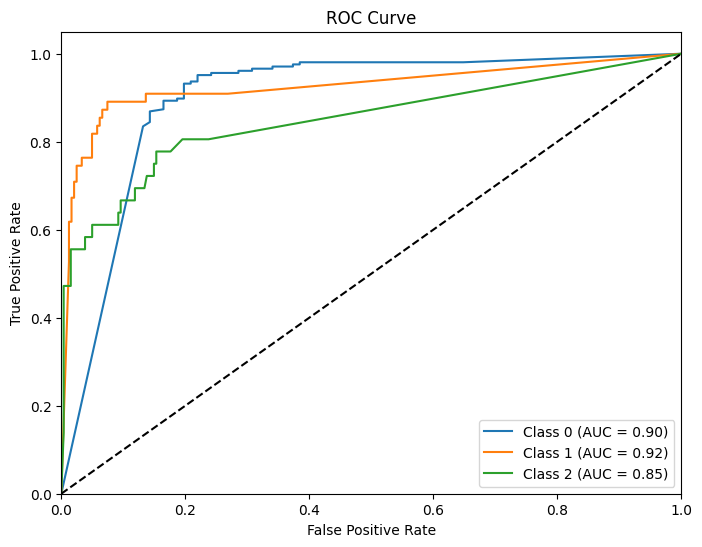

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_scores, num_classes=3):
    # predicted_scores를 numpy 배열로 변환
    predicted_scores = np.array(predicted_scores)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # 각 클래스에 대한 ROC Curve 및 AUC 계산
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve((np.array(true_labels) == i), predicted_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 모든 클래스에 대한 평균 ROC AUC 계산
    mean_roc_auc = np.mean(list(roc_auc.values()))
    print(f'Mean ROC AUC: {mean_roc_auc:.4f}')

    # ROC Curve 그리기
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig(f"../../../models/metric/oci-gan/{checkpoint_path.split('/multi/')[-1].split('/')[0]}.png")
    plt.show()

# 함수 호출 예시
plot_roc_curve(true_labels, predicted_scores, num_classes=3)


In [16]:
import os
import pandas as pd

# CSV 파일 목록 가져오기
csv_dir = '/home/eiden/eiden/octc-classification/models/metric/oci-gan'
csv_li = os.listdir(csv_dir)
csv_li = [csv for csv in csv_li if csv.endswith('.csv')]

# CSV 파일 읽기 및 데이터프레임에 추가
df = pd.DataFrame()
for csv in csv_li:
    csv_path = os.path.join(csv_dir, csv)
    if os.path.getsize(csv_path) > 0:  # 파일이 비어 있지 않은 경우에만 읽기
        temp = pd.read_csv(csv_path)
        df = pd.concat([df, temp], axis=0)

# 인덱스 리셋하기 (기존 인덱스 제거)
# df.reset_index(drop=True, inplace=True)
# 'model_name' 열에서 선행하는 0 제거
# df['model_name'] = df['model_name'].apply(lambda x: x.lstrip('0'))
df.index = df.index.map(lambda x: str(x).lstrip('0'))
df = df.sort_values(by='model_name', ascending=True)
df


,model_name,recall,specificity,ppv,npv,f1-score,acc,mean_auroc
,convnext_original_240326,0.855219,0.710961,0.848894,0.961165,0.844975,0.855219,0.903218
,convnext_original_ntr_240327,0.882155,0.758913,0.881106,0.975728,0.874997,0.882155,0.925336
,convnext_ours_240404,0.851852,0.713252,0.855486,0.966019,0.842554,0.851852,0.904945
,convnext_sono_ntr_240327,0.828283,0.654835,0.831530,0.966019,0.812356,0.828283,0.907316
,convnext_sonography_240326,0.838384,0.711222,0.833672,0.941748,0.830916,0.838384,0.904163
,swin_ours_240404,0.828283,0.650925,0.822938,0.956311,0.809944,0.828283,0.892764
,swin_v2_original_240327,0.868687,0.761325,0.862998,0.946602,0.864090,0.868687,0.910141
,swin_v2_original_ntr_240327,0.868687,0.737158,0.866099,0.966019,0.860178,0.868687,0.890795
,swin_v2_sonography_240326,0.831650,0.688261,0.824629,0.946602,0.823029,0.831650,0.906066
